In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense, Conv1D
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

2023-04-08 10:26:09.180882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 10:26:10.399473: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
## Deep Leaning class performs the following functions:
#### 1. Given type of data i.e. images or dataframe, it generates dataset from flow of directory
#### 2. Given a model and optimizer, it trains the neural net
class NeuralNet():
    def __init__(self, train_data_path, test_data_path, target_size=(0,0), is_image_data=True, epoch=None):
        self.is_image_data = is_image_data
        self.train_data_path = train_data_path
        self.test_data_path = test_data_path
        if((self.is_image_data)&(epoch==None)): self.epoch = 30
        elif((~self.is_image_data)&(epoch==None)): self.epoch = 300
        else: self.epoch = epoch
        self.target_size = target_size
        
    def dataset_generator(self, train_path, test_path, color_mode, class_mode, shuffle=True):
        ## ImageDataGenerator is used to create dataset of images from directory mentioned in the function
        traindata = ImageDataGenerator().flow_from_directory(directory=train_path, target_size=self.target_size, class_mode=class_mode,
                                                             color_mode=color_mode, shuffle=shuffle, batch_size=32)
        testdata = ImageDataGenerator().flow_from_directory(directory=test_path, target_size=self.target_size, class_mode=class_mode,
                                                             color_mode=color_mode, shuffle=shuffle, batch_size=32)

        return traindata, testdata
    
    def dataset_generator_cnn(self, train_path, test_path):
        train_data = pd.read_csv(train_path)
        test_data = pd.read_csv(test_path)

        ## Standardization
        scaler = StandardScaler()
        scaler.fit(train_data.drop(['label','name'],axis=1))
        x_train = scaler.transform(train_data.drop(['label','name'],axis=1))
        x_test = scaler.transform(test_data.drop(['label','name'],axis=1))

        ## PCA
        pca = PCA(.95)

        train_pca = pca.fit_transform(x_train)
        test_pca = pca.transform(x_test)

        ## Labels Preparation
        y_train = np.array(train_data.label)
        y_test = np.array(test_data.label)
        lb = LabelEncoder()
        y_train = np_utils.to_categorical(lb.fit_transform(y_train))
        y_test = np_utils.to_categorical(lb.transform(y_test))
        
        ## Expanding Dimensions
        x_train = np.expand_dims(train_pca, axis=2)
        x_test = np.expand_dims(test_pca, axis=2)
        
        return x_train, y_train, x_test, y_test
        
    def get_model(self):
        ## This will generate a model summary.
        print(self.model.summary())
        
    def fit(self, model, optimizer, loss, output_path):
        ## This will compile the model and make it ready for training.
        self.model = model
        self.get_model()
        self.model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])
        
        ## Checkpoint is used to store the best model during training process on the basis of validation set accuracy
        checkpoint = ModelCheckpoint(output_path, monitor='val_acc', verbose=1, save_best_only=True, 
                                     save_weights_only=False, mode='auto', period=1)
        
        ## Early stopping is used to avoid model overfitting. 
        ##If the model accuracy on validation set does not increase in 20 consecutive iterations the model will stop training further.
        early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
             
        ## Generate datasets
        if self.is_image_data:
            traindata, testdata = self.dataset_generator(self.train_data_path, self.test_data_path, color_mode='rgb', 
                                                         class_mode='categorical', shuffle=True)
            self.hist = self.model.fit_generator(generator=traindata, validation_data=testdata, epochs=self.epoch,
                                                 callbacks=[checkpoint,early])
        else:
            x_train, y_train, x_test, y_test = self.dataset_generator_cnn(self.train_data_path, self.test_data_path)
            self.hist = self.model.fit(x_train, y_train, batch_size=16, epochs=self.epoch,
                                       validation_data=(x_test, y_test), callbacks=[checkpoint, early])
        
        ## This will save model accuracy and loss and also check for early stopping and whether the model performs 
        ## better than the model in the previous iteration.

        ## Generate Loss and Accuracy plots
        self.accplot = self.get_plot([self.hist.history['acc'],self.hist.history['val_acc']],'a')
        self.lossplot = self.get_plot([self.hist.history['loss'],self.hist.history['val_loss']],'l')
    
    def get_plot(self, metric, typeof):
        if(typeof=='a'):
            title = "Model Accuracy"
            ylabel = "Accuracy"
            xlabel = "Epoch"
            legend = ["Accuracy","Validation Accuracy"]
        else:
            title = "Model Loss"
            ylabel = "Loss"
            xlabel = "Epoch"
            legend = ["Loss","Validation Loss"]  
        plt.figure(figsize=(20,10))
        plt.plot(metric[0])
        plt.plot(metric[1])
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.legend(legend)
        return plt

In [7]:
## For VGG 16 with Image Data
input_shape = (350,350,3)
model_input = Input(shape=input_shape, name='image_input')

#Get back the convolutional part of a VGG 16 network
model_vgg16 = VGG16(weights=None, include_top=False, input_tensor=model_input)

## Adding my own dense layer
model_output = model_vgg16(model_input)

vggmodel = Flatten(name='flatten')(model_output)
vggmodel = Dense(512, activation='relu', name='fc1')(vggmodel)
vggmodel = Dense(512, activation='relu', name='fc2')(vggmodel)
vggmodel = Dropout(0.5)(vggmodel)
vggmodel = Dense(16, activation='softmax', name='predictions')(vggmodel)

model = Model(inputs=model_input, outputs=vggmodel)

# Optimizer
# optimizer = keras.optimizers.SGD(lr = 0.00001, momentum=0.9, decay=0.0)
optimizer = keras.optimizers.Adam(lr = 0.00001)

neuralnet = NeuralNet('data/spectrograms/train', 'data/spectrograms/test', (input_shape[0],input_shape[1]), True, 1)
neuralnet.fit(model, optimizer, 'categorical_crossentropy', "model/VGG16 with Mel Spectrograms.h5")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 350, 350, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 10, 10, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 fc1 (Dense)                 (None, 512)               26214912  
                                                                 
 fc2 (Dense)                 (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 predictions (Dense)         (None, 16)                8208

/opt/dev-venv/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_10516/3044793733.py:74: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.hist = self.model.fit_generator(generator=traindata, validation_data=testdata, epochs=self.epoch,
2023-04-08 10:39:06.624262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/62 [========>.....................] - ETA: 9:44 - loss: 2.7898 - acc: 0.0688

KeyboardInterrupt: 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 65, 256)           2304      
                                                                 
 activation_18 (Activation)  (None, 65, 256)           0         
                                                                 
 conv1d_17 (Conv1D)          (None, 65, 256)           524544    
                                                                 
 batch_normalization_4 (Batc  (None, 65, 256)          1024      
 hNormalization)                                                 
                                                                 
 activation_19 (Activation)  (None, 65, 256)           0         
                                                                 
 dropout_11 (Dropout)        (None, 65, 256)           0         
                                                      

/opt/dev-venv/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


123/123 [==============================] - ETA: 0s - loss: 2.7755 - acc: 0.0831
Epoch 1: val_acc improved from -inf to 0.12627, saving model to model/CNN with Feature Array.h5
123/123 [==============================] - 13s 103ms/step - loss: 2.7755 - acc: 0.0831 - val_loss: 2.7552 - val_acc: 0.1263
Epoch 2/10
123/123 [==============================] - ETA: 0s - loss: 2.6723 - acc: 0.1117
Epoch 2: val_acc did not improve from 0.12627
123/123 [==============================] - 13s 102ms/step - loss: 2.6723 - acc: 0.1117 - val_loss: 2.7138 - val_acc: 0.0916
Epoch 3/10
123/123 [==============================] - ETA: 0s - loss: 2.5541 - acc: 0.1591
Epoch 3: val_acc improved from 0.12627 to 0.13849, saving model to model/CNN with Feature Array.h5
123/123 [==============================] - 13s 108ms/step - loss: 2.5541 - acc: 0.1591 - val_loss: 2.5428 - val_acc: 0.1385
Epoch 4/10
123/123 [==============================] - ETA: 0s - loss: 2.1827 - acc: 0.2167
Epoch 4: val_acc improved from 0.1

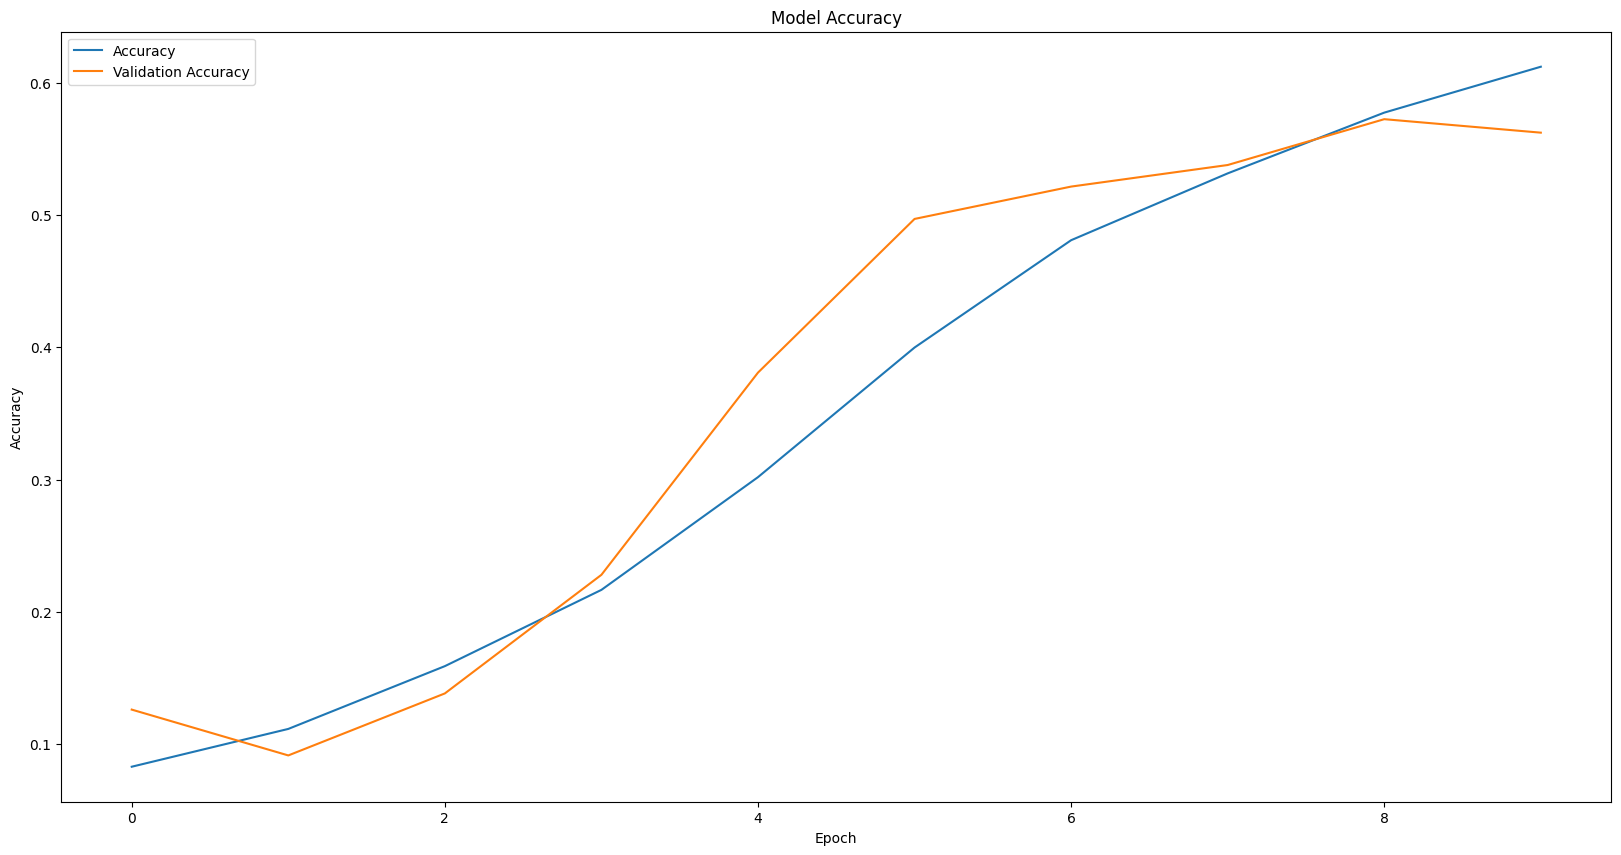

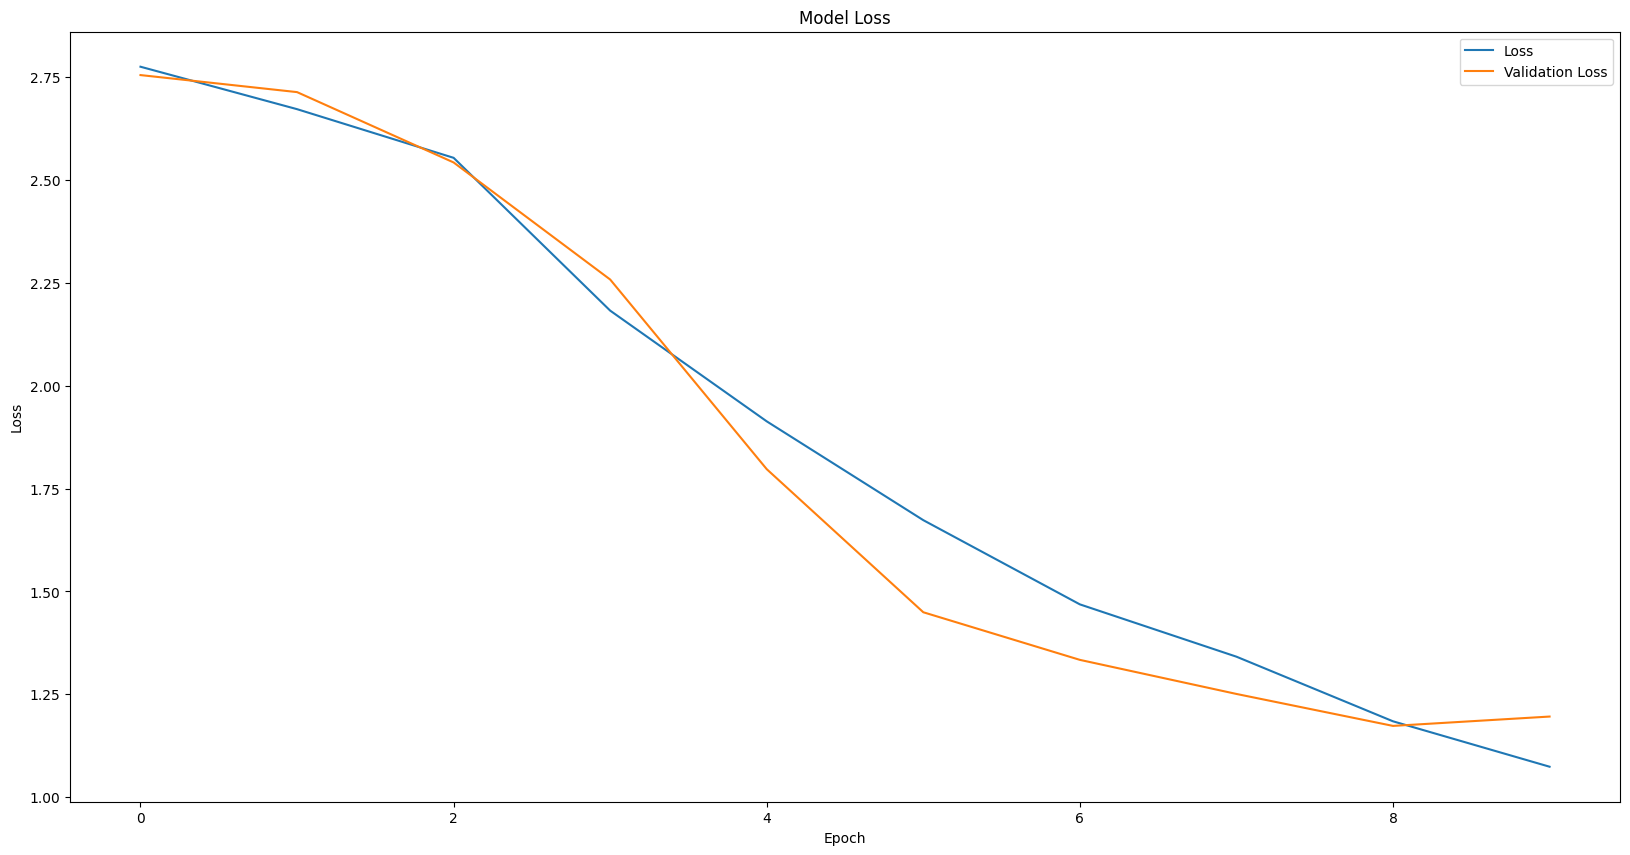

In [14]:
## For CNN with Dataframe of MFCC, MEL Scale, and Chroma
from keras import regularizers

model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(65,1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(16))
model.add(Activation('softmax'))

optimizer = keras.optimizers.SGD(lr = 0.0001, momentum=0.9, decay=0.01)

neuralnet = NeuralNet("data/waves/train_wave_features.csv", "data/waves/test_wave_features.csv", is_image_data=False, epoch=10)
neuralnet.fit(model, optimizer, 'categorical_crossentropy', "model/CNN with Feature Array.h5")